# Particle Resolved Coagulation Using the Super Droplet Method

## Introduction

In aerosol science, understanding particle-particle interactions is crucial for predicting the evolution of particle size distributions. One such interaction is **coagulation**, where two particles collide and merge into a larger particle. Modeling coagulation accurately can be computationally expensive, especially when tracking individual particles. 

The **super droplet method** is a technique that allows for the efficient simulation of coagulation in a computationally feasible manner. It represents a large number of real particles with a smaller number of computational particles (super droplets), each carrying a statistical weight that reflects the number of real particles it represents.

This notebook provides a step-by-step guide to simulating coagulation using the super droplet method with a particle-resolved approach.

## Setup and Imports

We'll start by importing the necessary libraries and setting up the environment.


In [1]:
# %% particle resolved coagulation example
import numpy as np  # For numerical operations and array manipulations
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

# Import specific modules from the particula package
from particula.next.dynamics.coagulation import brownian_kernel
from particula.next.dynamics.coagulation import super_droplet_method

from particula.next.particles.properties.lognormal_size_distribution import (
    lognormal_sample_distribution,
)

## Generating a Lognormal Spacing

In this section, we generate a sample particle size distribution following a lognormal distribution. The lognormal distribution is commonly used in aerosol science to describe particle size distributions. 

## Coagulation Kernel

We also calculate the Brownian coagulation kernel for these particles, which quantifies the probability of coagulation between particles of different sizes.

## Random seed

We set a random seed to ensure reproducibility of the results.

In [2]:
# lognormal spacing

radius_bins = np.logspace(
    -9, -6, num=20
)  # Define the radius bins for the distribution
mass_bins = (
    4 / 3 * np.pi * radius_bins**3 * 1000
)  # Calculate the mass of the particles in the bins

kernel_bins = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=298.15,
    pressure=101325,
)  # Calculate the Brownian coagulation kernel for the radius bins

rng = np.random.default_rng(12345)

## Sampling the Particle Distribution

We then sample particles from the lognormal distribution. These particles will be sorted by size to prepare for the coagulation step.

In [3]:
# %% sample particle distribution
particle_radius = lognormal_sample_distribution(
    mode=np.array([1e-8, 1e-7]),
    geometric_standard_deviation=np.array([1.4, 1.4]),
    number_of_particles=np.array([5000, 1000]),
    number_of_samples=1000,
)
particle_radius = np.sort(particle_radius)
particles_original = particle_radius.copy()

## Coagulation Step Using the Super Droplet Method

In the coagulation step, particles collide and merge over a given time step. The super droplet method efficiently simulates this process by adjusting the particle sizes and concentrations based on the calculated kernel and the specified volume and time step.

In [4]:
# %% Coagulation step

delta_t = 1  # time step in seconds

random_concentration = np.random.uniform(1, 10, size=particle_radius.size)
particle_concentration = (
    np.ones_like(particle_radius) * random_concentration * 1e6
)  # particles per m^3
particle_concentration = particle_concentration.astype(np.float64)
volume_sim = 1  # m^3

particle_radius, particle_concentration = (
    super_droplet_method.coagulation_step(
        particle_radius=particle_radius,
        particle_concentration=particle_concentration,
        kernel=kernel_bins,
        kernel_radius=radius_bins,
        volume=volume_sim,
        time_step=delta_t,
        random_generator=rng,
    )
)

volume_final = np.power(particle_radius, 3)
volume_concentration_final = volume_final * particle_concentration
volume_total_final = np.sum(volume_concentration_final)

print(f"Final volume: {volume_total_final}")
print(f"Final number of particles: {np.sum(particle_concentration)}")

Final volume: 1.7513691992283998e-12
Final number of particles: 3866207246.663141


## Plotting the New Distribution

Finally, we plot the particle size distribution before and after coagulation. This visualization helps us understand the effect of the coagulation process on the particle size distribution.


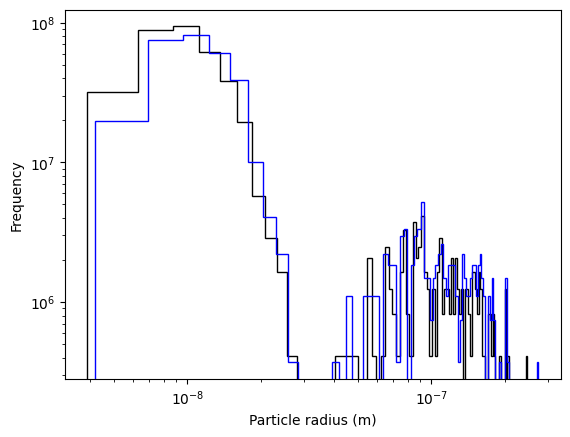

In [6]:
# %% plot new distribution
fig, ax = plt.subplots()
ax.hist(
    particles_original, bins=100, histtype="step", color="black", density=True
)
ax.hist(
    particle_radius, bins=100, histtype="step", color="blue", density=True
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Frequency")
plt.show()

## Conclusion

This notebook demonstrated the use of the super droplet method to simulate particle coagulation in a computationally efficient manner. By representing multiple real particles with fewer computational particles, we can model complex aerosol dynamics over time without the need for excessive computational resources.
